# Post Processing a 2D Path

Eureka Robotics Internship Application by Gabriel James Goenawan<br>
I'm re-using my code from Challenge 1 to generate the required paths.

In [2]:
import pylab as pl
import numpy as np
import sys
from time import sleep
import random
sys.path.append('osr_course_pkgs/osr_examples/scripts/')
import environment_2d

max_nodes = 200 # Change the one on the A* Algorithm Cell as well
max_distance_between_nodes = 2
intersection_detector_resolution = 100

def squared_distance(x0, y0, x1, y1):
    return ((x0-x1)**2)+((y0-y1)**2)

np.random.seed(4)
env = environment_2d.Environment(10, 6, 5)
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q

#Generating random nodes
nodes = []

nodes.append([x_start, y_start])
for i in range (0, max_nodes):
    temp_x = random.uniform(0.0, 10.0)
    temp_y = random.uniform(0.0, 6.0)
    while env.check_collision(temp_x, temp_y):
        temp_x = random.uniform(0.0, 10.0)
        temp_y = random.uniform(0.0, 6.0)
    nodes.append([temp_x, temp_y])
nodes.append([x_goal, y_goal])

#Finding Connections
max_distance_between_nodes_squared = max_distance_between_nodes **2
valid_paths = []
for i in range (0, max_nodes+2):
    available_connections = []
    for j in range (0, max_nodes+2):
        if j == i:
            continue
        distance_between_points = squared_distance(nodes[i][0], nodes[i][1], nodes[i][0], nodes[j][1])
        if (distance_between_points  > max_distance_between_nodes_squared):
            continue
        else: 
            path_collide = False
            for n in range (1,intersection_detector_resolution):
                #Intersection detector
                if env.check_collision(nodes[i][0]+(nodes[j][0]-nodes[i][0])*n/intersection_detector_resolution, nodes[i][1]+(nodes[j][1]-nodes[i][1])*n/intersection_detector_resolution):
                    path_collide = True
                    break
            if path_collide == False:
                available_connections.append([j, distance_between_points])
    valid_paths.append(available_connections)

class node():
    def __init__(self, parent, node_id, coordinate_list, current_costs):
        self.parent = parent
        self.node_id = node_id
        self.current_costs = current_costs
        self.total_costs = current_costs + squared_distance(coordinate_list[0], coordinate_list[1], x_goal, y_goal)
    
    def __eq__(self, other):
        if other == None:
            return self.node_id == None
        else:
            return self.node_id == other.node_id

#Initiating Start and End Condition
start = node(None, 0, nodes[0], 0)
goal = node(None, max_nodes+1, nodes[max_nodes+1], 0)
open_list = [start]
closed_list = []
found_path = []
path_length = 0

#A* Algorithm
while len(open_list)>0:
    optimal_node_costs = None
    optimal_node = None
    for i in open_list:
        if optimal_node_costs == None or i.total_costs < optimal_node_costs:
            optimal_node_costs = i.total_costs
            current_node = i
    open_list.remove(current_node)
    closed_list.append(current_node)
    if current_node == goal:
        path_length = current_node.current_costs
        while current_node.parent != None :
            found_path.append(current_node.node_id)
            current_node = current_node.parent
        
        found_path.append(0)
        break
    else:
        for i in valid_paths[current_node.node_id]:
            child_node = node(current_node, i[0], nodes[i[0]], (current_node.current_costs + i[1]))
            if child_node not in closed_list:
                for j in open_list:
                    if child_node not in open_list and j==child_node and j.current_costs > child_node.current_costs:
                        open_list.append(child_node)
                if child_node not in open_list:
                    open_list.append(child_node)
                    
if len(found_path)>0:
    print("Optimal Path Found!")
else:
    print("Path not Found")

Optimal Path Found!


# Shortcut Generation

Generate possbile shortcut by randomizing a 2 points in each connecting line & tries to connect them together. If no obstables hit & the path is shorter, the shortcut is saved with below format:

shortcut for node n = <br>`[[[point 1 & 2 x coordinate],[point 1 & 2 y coordinate]], distance from node n-1 to node n+1 ( skipping node n]`<br>
These shortcuts then put into a list called `possible_shortcuts` which is properly arranged. (index 0 is for shortcut of node 0)

<br><br>
`max_iteration` - Defines how many time samples will be generated for each node<br>
`intersection_detector_resolution` - The lower the value, the less likely the path will goes through a thin obstacle.

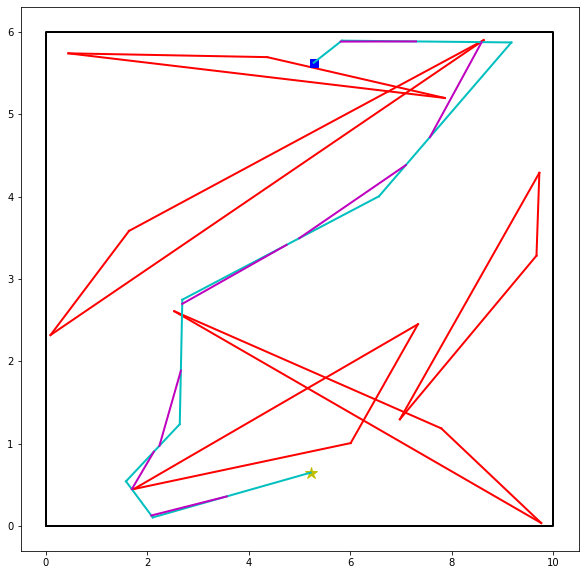

In [26]:
max_iteration = 100
intersection_detector_resolution = 100

np.random.seed(4)
env = environment_2d.Environment(10, 6, 5)
pl.figure(figsize = (10,10))
pl.ion()
pl.clf()
env.plot()
q = env.random_query()
if q is not None:
  x_start, y_start, x_goal, y_goal = q
  env.plot_query(x_start, y_start, x_goal, y_goal)

for i in range (1, len(found_path)):
    pl.plot([nodes[found_path[i-1]][0], nodes[found_path[i]][0]], [nodes[found_path[i-1]][1], nodes[found_path[i]][1]] ,"c", linewidth=2)

#Generating default path with proper formatting.
initial_path_length = 0
possible_shortcuts = []
for i in range (0, len(found_path)):
    if i == 0 or i==len(found_path)-1:
        possible_shortcuts.append(None)
    else:
        temp_distance = squared_distance(nodes[found_path[i-1]][0], nodes[found_path[i-1]][1], nodes[found_path[i]][0], nodes[found_path[i]][1]) + squared_distance(nodes[found_path[i+1]][0], nodes[found_path[i+1]][1], nodes[found_path[i]][0], nodes[found_path[i]][1])
        initial_path_length+=temp_distance
        possible_shortcuts.append([[None, None], temp_distance])
        
#Finding shortcuts
for rep in range (0, max_iteration):
    for i in range (1, len(found_path)-1):
        #select vertex 1
        random_float = random.random()
        v1_x = nodes[found_path[i]][0] + (nodes[found_path[i-1]][0] - nodes[found_path[i]][0])*random_float
        v1_y = nodes[found_path[i]][1] + (nodes[found_path[i-1]][1] - nodes[found_path[i]][1])*random_float
        #select vertex 2
        random_float = random.random()
        v2_x = nodes[found_path[i]][0] + (nodes[found_path[i+1]][0] - nodes[found_path[i]][0])*random_float
        v2_y = nodes[found_path[i]][1] + (nodes[found_path[i+1]][1] - nodes[found_path[i]][1])*random_float
        
        collide = False
        for n in range (0,intersection_detector_resolution):
            if env.check_collision(v1_x+(v2_x-v1_x)*n/intersection_detector_resolution, v1_y+(v2_y-v1_y)*n/intersection_detector_resolution):
                collide = True
        if collide == False:
            #determining the if found shortcut has better distance
            resulting_distance = squared_distance(nodes[found_path[i-1]][0], nodes[found_path[i-1]][1], v1_x, v1_y) + squared_distance(v2_x, v2_y, v1_x, v1_y) + squared_distance(nodes[found_path[i+1]][0], nodes[found_path[i+1]][1], v2_x, v2_y)
            if resulting_distance < possible_shortcuts[i][1]:
                possible_shortcuts[i] = [[[v1_x,v2_x],[v1_y, v2_y]], resulting_distance]

#printing final shortcuts
for i in possible_shortcuts:
    if i != None and i[0]!=[None,None]:
        pl.plot(i[0][0], i[0][1] ,"m", linewidth=2)

The Magenta Lines represent possible shortcuts

In [27]:
final_path_length = 0
for i in possible_shortcuts:
    if i != None:
        final_path_length += i[1]

print("Initial Path Length =", initial_path_length)
print("Final Path Length   =", final_path_length)
    

Initial Path Length = 95.21603457230046
Final Path Length   = 54.67177513472841
